In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display, display_markdown

SEED = 0

## Load dataset

In [2]:
df = pd.read_csv("../diabetes_prediction_dataset.csv")

In [3]:
df.head(20)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


## Perform cleaning and preprocessing

### Detect and remove invalid values

In [4]:
# Make a dataframe to count the null, na, and negative values
invalid_values = pd.DataFrame()
for col in df.columns:
    if df[col].dtype in ["int64", "float64"]:
        invalid_values[col] = [
            df[col].isnull().sum(),
            df[col].isna().sum(),
            (df[col] < 0).sum(),
        ]
    else:
        invalid_values[col] = [df[col].isnull().sum(), df[col].isna().sum(), np.NaN]
invalid_values.index = ["Null count", "NaN count", "Negative count"]

display(invalid_values)
print("There are no null, NaN, or negative values in the dataset that need cleaning.\n")

print(f"Duplicated Rows: {df.duplicated().sum()}")
# There are 3854 duplicate rows, let's drop them
df_clean = df.drop_duplicates()

# There are 3998 "ever" values in the 'smoking_history' column, this looks like a typo
# So let's replace it with 'never'
print(
    f"""
There are {len(df_clean[df_clean['smoking_history'] == 'ever'])} "ever" values in the smoking_history column.
This looks like a typo, so we will replace it with "never".
"""
)
df_clean.loc[df_clean["smoking_history"] == "ever", "smoking_history"] = "never"

print(f"There are {len(df_clean)} clean rows left after dropping duplicates.")

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
Null count,0.0,0,0,0,0.0,0,0,0,0
NaN count,0.0,0,0,0,0.0,0,0,0,0
Negative count,NaN,0,0,0,NaN,0,0,0,0


There are no null, NaN, or negative values in the dataset that need cleaning.

Duplicated Rows: 3854

There are 3998 "ever" values in the smoking_history column.
This looks like a typo, so we will replace it with "never".

There are 96146 clean rows left after dropping duplicates.


### Preprocess data into numerical and categorical features

In [5]:
categorical_columns = set(
    ["diabetes", "heart_disease", "hypertension", "gender", "smoking_history"]
)
df_quantitative_columns = set(df_clean.columns).difference(set(categorical_columns))
df_quantitative = df_clean[list(df_quantitative_columns)]
df_categorical = df_clean[list(categorical_columns)]

## Perform exploratory data analysis

### Descriptive statistics

In [6]:
# Creating a dictionary to store the labeled dataframes
categorical_summary_dfs = {
    col: pd.concat(
        [
            df_categorical[col].value_counts(normalize=True),
            df_categorical[col].value_counts(),
        ],
        axis=1,
        keys=["proportion", "count"],
    )
    for col in df_categorical
}

# Concatenating along axis=0 with keys as column labels
categorical_summary_df = pd.concat(categorical_summary_dfs, axis=0)

# Displaying the dataframe
display(categorical_summary_df)

proportion  count
smoking_history never          0.399351  38396
                No Info        0.342053  32887
                former         0.096717   9299
                current        0.095657   9197
                not current    0.066222   6367
diabetes        0              0.911780  87664
                1              0.088220   8482
hypertension    0              0.922399  88685
                1              0.077601   7461
gender          Female         0.584122  56161
                Male           0.415691  39967
                Other          0.000187     18
heart_disease   0              0.959197  92223
                1              0.040803   3923

In [7]:
display_markdown(
    f"""This dataset contains {len(df_clean)} rows and {len(df_clean.columns)} columns.

The majority of subjects in this dataset are non-diabetic.  
{categorical_summary_df['count']['diabetes'][0]} non-diabetic subjects  
{categorical_summary_df['count']['diabetes'][1]} diabetic subjects  
{categorical_summary_df['proportion']['diabetes'][1] * 100:.2f}% diabetic proportion  

{categorical_summary_df['proportion']['hypertension'][1] * 100:.2f}% of subjects have hypertension  
{categorical_summary_df['proportion']['heart_disease'][1] * 100:.2f}% of subjects have heart disease  

TODO: Descrive the smoking history column.

This sample has a balanced number of male and female subjects. {categorical_summary_df['proportion']['gender']['Male'] * 100:.2f}% of subjects are male.""",
    raw=True,
)

This dataset contains 96146 rows and 9 columns.

The majority of subjects in this dataset are non-diabetic.  
87664 non-diabetic subjects  
8482 diabetic subjects  
8.82% diabetic proportion  

7.76% of subjects have hypertension  
4.08% of subjects have heart disease  

TODO: Descrive the smoking history column.

This sample has a balanced number of male and female subjects. 41.57% of subjects are male.

#### 5-number summary of dataset's quantitative features

In [8]:
df_summary = df_quantitative.describe()
df_summary.drop(labels=["count"], inplace=True)
display(df_summary)

,blood_glucose_level,bmi,age,HbA1c_level
mean,138.218231,27.321461,41.794326,5.532609
std,40.909771,6.767716,22.462948,1.073232
min,80.000000,10.010000,0.080000,3.500000
25%,100.000000,23.400000,24.000000,4.800000
50%,140.000000,27.320000,43.000000,5.800000
75%,159.000000,29.860000,59.000000,6.200000
max,300.000000,95.690000,80.000000,9.000000


HbA1c Level: The average is 5.53, with a standard deviation of 1.07. The range spans from 3.5 to 9.0, showing substantial variability.  

BMI: The mean BMI is 27.32, with a large standard deviation of 6.77. The minimum is 10.01 and the maximum is 95.69, suggesting a large number of outliers.  

Age: With a mean of 41.79 and a standard deviation of 22.46, this sample has a lot of age diversity. The youngest subject is 0.08 years old, and the oldest is 80 years. Little or no outliers are expected in this feature.  

Blood Glucose Level: The mean level is 138.22, with a standard deviation of 40.91. The minimum is 80 and the maximum is 300. Values over 160 are considered hyperglycemic.

#### 5-number summary of non-diabetic quantitative features

In [9]:
df_nondiabetic_summary = df_clean[df_clean["diabetes"] == 0][
    list(df_quantitative_columns)
].describe()
display(df_nondiabetic_summary)

,blood_glucose_level,bmi,age,HbA1c_level
count,87664.000000,87664.000000,87664.000000,87664.000000
mean,132.818489,26.869003,39.943229,5.396936
std,34.241382,6.509884,22.228281,0.970833
min,80.000000,10.010000,0.080000,3.500000
25%,100.000000,23.000000,22.000000,4.800000
50%,140.000000,27.320000,40.000000,5.800000
75%,158.000000,29.180000,57.000000,6.200000
max,200.000000,95.690000,80.000000,6.600000


#### 5-number summary of diabetic quantitative features

In [10]:
df_diabetic_summary = df_clean[df_clean["diabetes"] == 1][
    list(df_quantitative_columns)
].describe()
display(df_diabetic_summary)

,blood_glucose_level,bmi,age,HbA1c_level
count,8482.000000,8482.000000,8482.000000,8482.000000
mean,194.026173,31.997755,60.925961,6.934827
std,58.630047,7.563494,14.545301,1.076462
min,126.000000,10.980000,3.000000,5.700000
25%,145.000000,27.320000,52.000000,6.100000
50%,160.000000,29.985000,62.000000,6.600000
75%,240.000000,35.940000,72.000000,7.500000
max,300.000000,88.720000,80.000000,9.000000


All sample statistics of HbA1c for diabetic subjects is are higher than non-diabetic subjects. This may indicate that diabetic subjects have higher HbA1c levels on average.

Similarly, all sample statistics for blood glucose levels are higher for diabetic subjects than non-diabetic subjects, suggesting that diabetic subjects have higher blood glucose levels on average. 50% of diabetic subjects have blood glucose levels over 160, which is considered hyperglycemic, while fewer than 75% of non-diabetic subjects have blood glucose levels over 160.

Nearly all statistics, with the exception of the maximum, are higher for bmi in diabetic subjects compared to non-diabetic subjects. This suggests that diabetic subjects tend to have higher BMI values on average.

The average age of diabetic subjects is higher than non-diabetic subjects, and the standard deviation is smaller, indicating that subjects with diabetes may be older and closer in age than non-diabetic subjects.

In [11]:
print(
    f"""The dataset contains {len(df_clean)} rows and {len(df_clean.columns)} columns.

The quantitative columns are: {list(df_quantitative_columns)}.

The dataset has 
"""
)

The dataset contains 96146 rows and 9 columns.

The quantitative columns are: ['blood_glucose_level', 'bmi', 'age', 'HbA1c_level'].

The dataset has 



### Discriptive statistics visualizations

In [12]:
import seaborn as sns

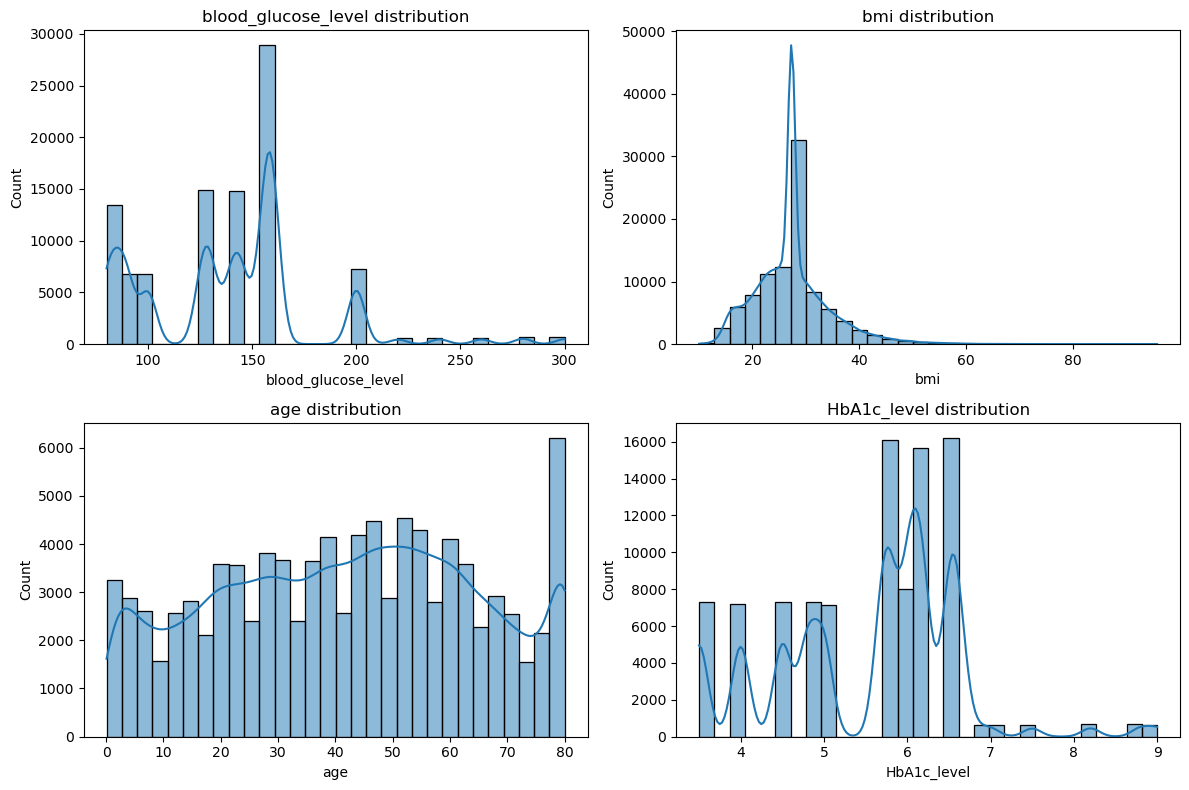

In [13]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df_quantitative_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_quantitative[col], kde=True, bins=30)
    plt.title(f"{col} distribution")
plt.tight_layout()
plt.show()

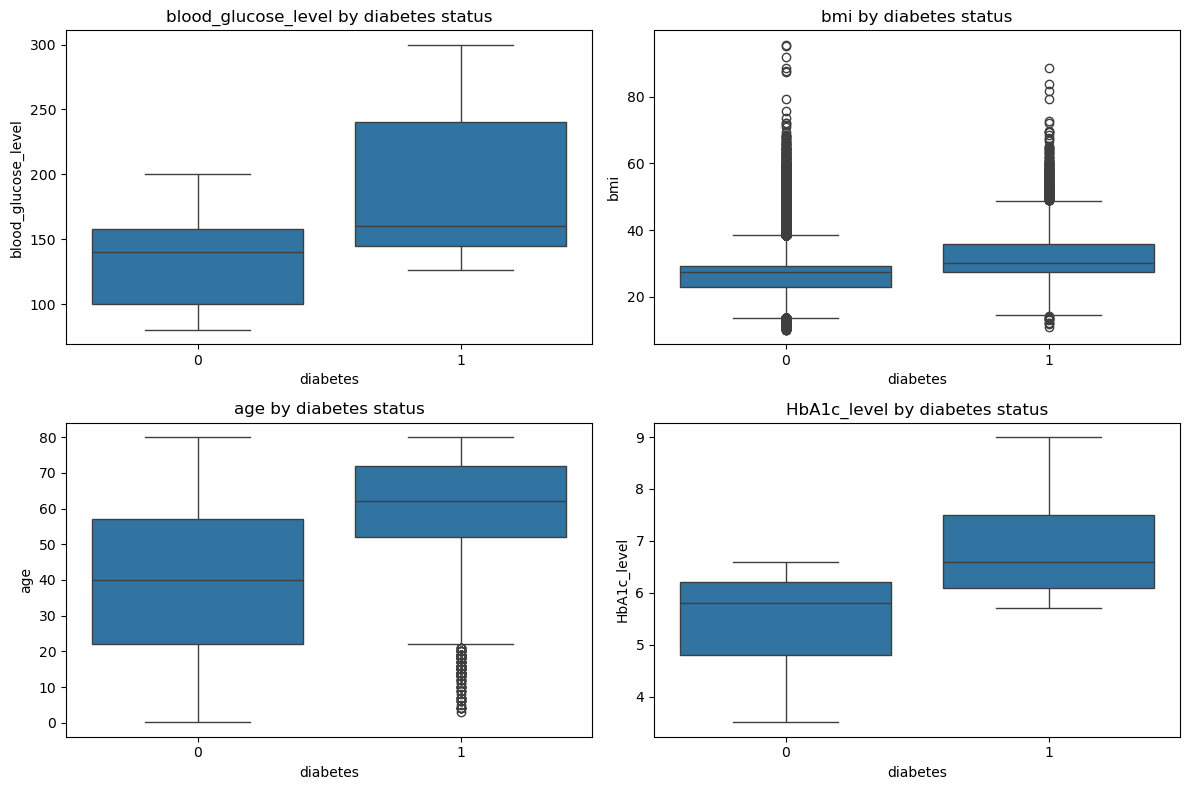

In [14]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df_quantitative_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df_clean["diabetes"], y=df_clean[col])
    plt.title(f"{col} by diabetes status")
plt.tight_layout()
plt.show()

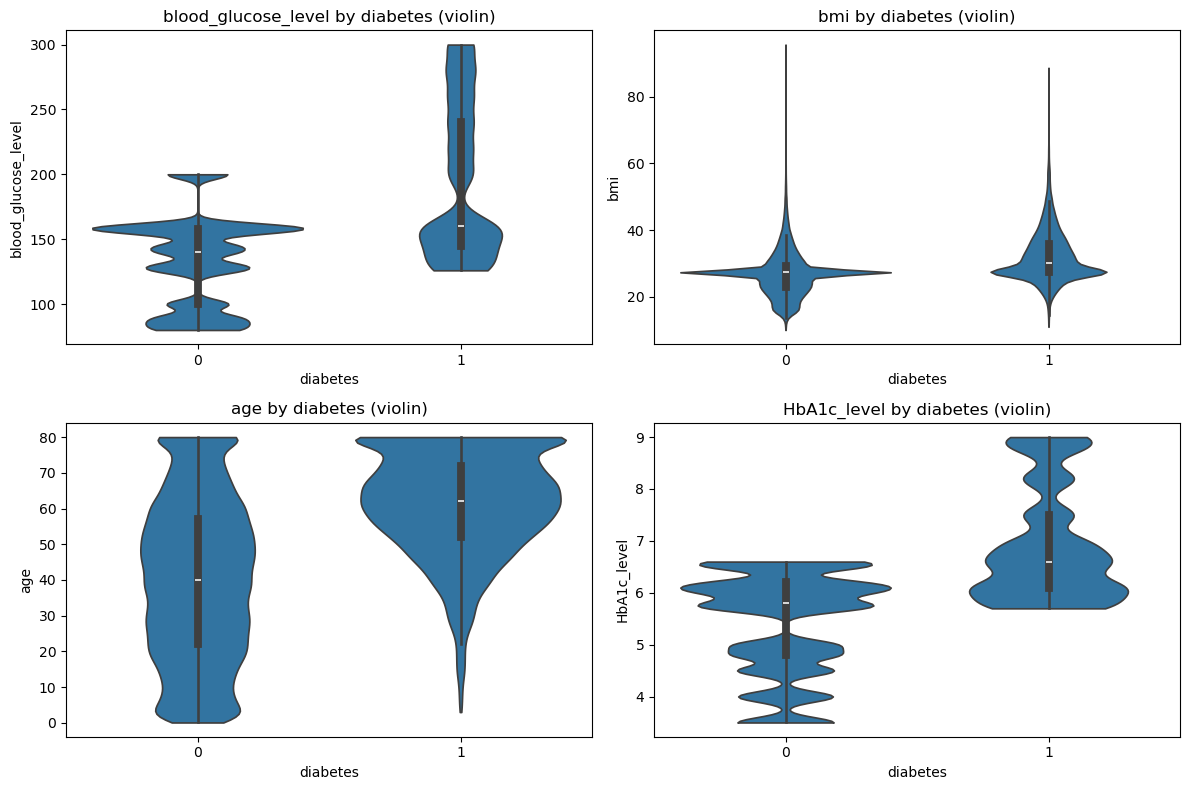

In [15]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df_quantitative_columns, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(x="diabetes", y=col, data=df_clean, inner="box", cut=0)
    plt.title(f"{col} by diabetes (violin)")
plt.tight_layout()
plt.show()

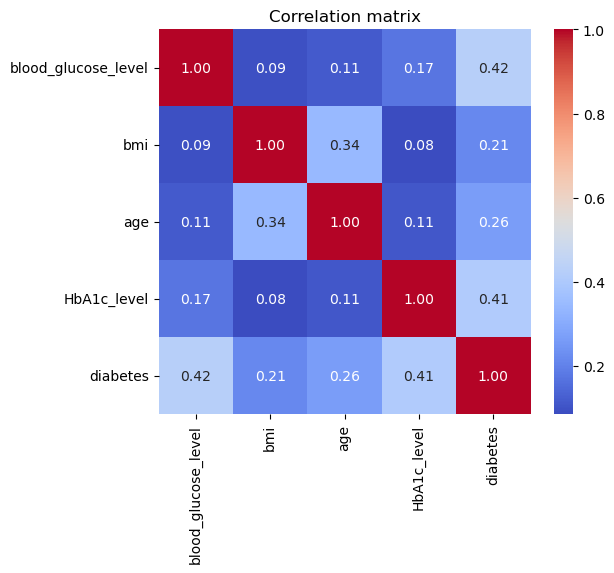

In [16]:
plt.figure(figsize=(6, 5))
corr = df_quantitative.join(df_clean["diabetes"]).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix")
plt.show()

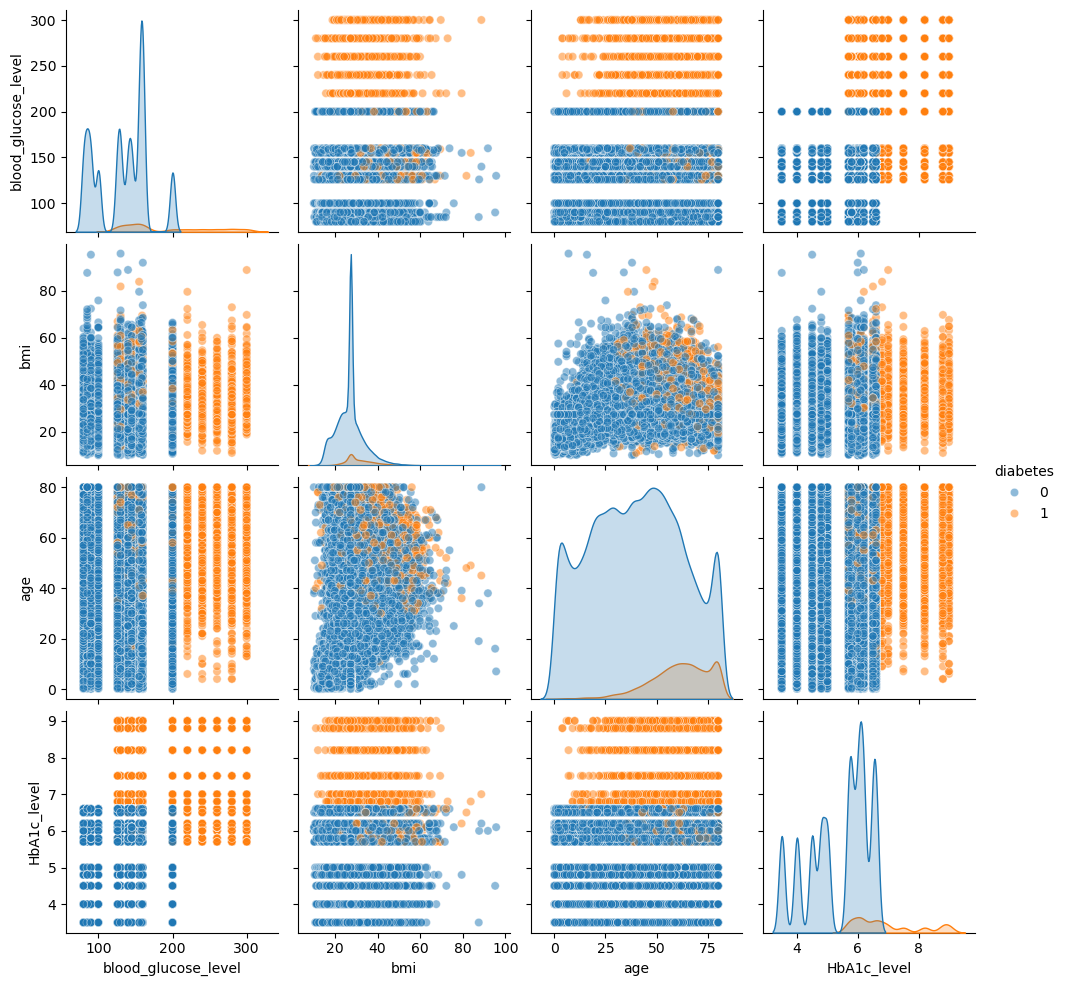

In [17]:
sns.pairplot(
    df_clean,
    vars=df_quantitative_columns,
    hue="diabetes",
    diag_kind="kde",
    plot_kws={"alpha": 0.5},
    height=2.5,
)
plt.show()

In [18]:
from scipy.stats import chi2_contingency, ttest_ind
import pandas as pd

continuous_cols = ["HbA1c_level", "age", "bmi", "blood_glucose_level"]

for col in continuous_cols:
    group1 = df_clean[df_clean["diabetes"] == 1][col]
    group0 = df_clean[df_clean["diabetes"] == 0][col]
    t_stat, p_val = ttest_ind(group1, group0, equal_var=False)

    mean1 = group1.mean()
    mean0 = group0.mean()

    print(f"--- T-test for '{col}' ---")
    print(f"Mean (Diabetic):     {mean1:.2f}")
    print(f"Mean (Non-Diabetic): {mean0:.2f}")
    print(f"T-statistic:         {t_stat:.3f}")
    print(f"P-value:             {p_val:.3f}")
    print(
        "Conclusion:          ",
        "Significant difference" if p_val < 0.05 else "No significant difference",
    )
    print()

categorical_cols = ["smoking_history", "hypertension", "gender", "heart_disease"]

for col in categorical_cols:
    contingency_table = pd.crosstab(df_clean[col], df_clean["diabetes"])
    chi2_stat, p_val_chi2, dof, expected = chi2_contingency(contingency_table)

    print(f"--- Chi-squared Test for '{col}' ---")
    print(f"Chi-squared statistic: {chi2_stat:.3f}")
    print(f"P-value:               {p_val_chi2:.3f}")
    print(
        "Conclusion:            ",
        "Association exists" if p_val_chi2 < 0.05 else "No association",
    )
    print()

--- T-test for 'HbA1c_level' ---
Mean (Diabetic):     6.93
Mean (Non-Diabetic): 5.40
T-statistic:         126.685
P-value:             0.000
Conclusion:           Significant difference

--- T-test for 'age' ---
Mean (Diabetic):     60.93
Mean (Non-Diabetic): 39.94
T-statistic:         119.991
P-value:             0.000
Conclusion:           Significant difference

--- T-test for 'bmi' ---
Mean (Diabetic):     32.00
Mean (Non-Diabetic): 26.87
T-statistic:         60.326
P-value:             0.000
Conclusion:           Significant difference

--- T-test for 'blood_glucose_level' ---
Mean (Diabetic):     194.03
Mean (Non-Diabetic): 132.82
T-statistic:         94.599
P-value:             0.000
Conclusion:           Significant difference

--- Chi-squared Test for 'smoking_history' ---
Chi-squared statistic: 1708.593
P-value:               0.000
Conclusion:             Association exists

--- Chi-squared Test for 'hypertension' ---
Chi-squared statistic: 3680.033
P-value:               0.0